<a href="https://colab.research.google.com/github/CTA-MLDS/sentiment-analysis/blob/main/data_set_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install transformers datasets

In [ ]:
! pip install transformers --upgrade

In [ ]:
! pip install fugashi ipadic

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
# Hugging Face (Transformers) 関連のモジュール
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import Dataset, load_metric

In [ ]:
# [前準備] Matplotlib で日本語フォントを使用できるようにする
# cf. https://blog.3qe.us/entry/2018/08/16/121457
!apt-get -y install fonts-ipafont-gothic
!rm /root/.cache/matplotlib/fontlist-v310.json
# jupyter notebookで動くように書き換え↓
# ! pip install matplotlib
# ! pip install japanize-matplotlib

# NOTE ここで、ランタイムを再起動

In [ ]:
!sudo apt-get install fonts-ipafont-gothic
!sudo fc-cache -fv
!rm /root/.cache/matplotlib/fontlist-v310.json

In [ ]:
! pip install japanize-matplotlib

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

In [ ]:
# if 'IPAGothic' not in plt.rcParams['font.family']:
#     plt.rcParams['font.family'] = 'MS Gothic'

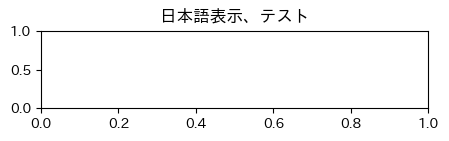

In [ ]:
# 動作確認
plt.figure(figsize=(5, 1))
plt.title('日本語表示、テスト')
plt.show()

In [ ]:
# GitHubよりWRIMEデータをダウンロードする
#
# WRIME dataset : https://github.com/ids-cv/wrime
# 今回使用するのは ver1 （感情極性が付与されていない版）

! wget https://github.com/ids-cv/wrime/raw/master/wrime-ver1.tsv

# question to ask
# tried to run the command through this cell, didn't work.
# installed wget, but couldn't execute the file
# manually moved the file to the system32 file of windows and ran the program through cmd (and worked??)

# fugashiがインストールできない
# -> mecab.hが認識されない -> 通常はincludeサブディレクトリにあるはずだが、代わりにsrcに入っている（そしてincludeは存在していない）
# -> mecabを再度インストール -> mecabのバージョンをチェックしたいmecab --versionが、エラー（'mecab' is not recognized as an internal or external command,
# operable program or batch file.）-> 環境変数にpathを追加 -> INCLUDE変数も追加 -> やっぱりmecab.hが認識されない
# mecabのビルド済みバイナリをインストール　pip install mecab-python-binary　pip install mecab-python3　pip install mecab-python3 --global-option="--with-cflags=-IC:\Users\minaa\OneDrive\TCA\mecab\mecab\mecab\src"
# fugashiを諦めます


In [ ]:
# pandas.DataFrameとして読み込む
df_wrime = pd.read_table('wrime-ver1.tsv')
df_wrime.head(2)

In [ ]:
emotion_names = ['Joy', 'Sadness', 'Anticipation', 'Surprise', 'Anger', 'Fear', 'Disgust', 'Trust']
num_labels = len(emotion_names)
# objective emotion average (Avg. Readers_*) values are converted to list, defined as a new column
df_wrime['readers_emotion_intensities'] = df_wrime.apply(lambda x: [x['Avg. Readers_' + name] for name in emotion_names], axis=1)

# removing samples with less emotion intensities
# (max.readers_emotion_intensities must be 2 or more)
is_target = df_wrime['readers_emotion_intensities'].map(lambda x: max(x) >= 2)
df_wrime_target = df_wrime[is_target]

In [ ]:
# divide into train and test data
df_groups = df_wrime_target.groupby('Train/Dev/Test')
df_train = df_groups.get_group('train')
df_test = pd.concat([df_groups.get_group('dev'), df_groups.get_group('test')])
# print('train :', len(df_train))
# print('test :', len(df_test))

In [ ]:
# 使用するモデルを指定して、Tokenizerを読み込む
checkpoint = 'cl-tohoku/bert-base-japanese-whole-word-masking'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
#  (1) 使用するモデルをより簡素なものに
# checkpoint = 'distilbert-base-japanese'
# tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
# (2) モデルの一部の層を削減して軽量化
from transformers import AutoModel, AutoConfig
config = AutoConfig.from_pretrained(checkpoint, num_hidden_layers=6)  # 6層に変更
model = AutoModel.from_pretrained(checkpoint, config=config)

In [ ]:
# (3) モデルのEmbedding層の次元を削減
config = AutoConfig.from_pretrained(checkpoint, hidden_size=252)
model = AutoModel.from_pretrained(checkpoint, config=config, ignore_mismatched_sizes=True)


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import AdamW, get_linear_schedule_with_warmup
from datasets import load_metric

In [ ]:
# 前処理関数: tokenize_function
# 感情強度の正規化（総和=1）も同時に実施する
def tokenize_function(batch):
    tokenized_batch = tokenizer(batch['Sentence'], truncation=True, padding='max_length', return_tensors="pt")
    tokenized_batch['labels'] = torch.tensor([x / np.sum(x) for x in batch['readers_emotion_intensities']], dtype=torch.float32)
    return tokenized_batch

# Transformers用のデータセット形式に変換
# pandas.DataFrame -> datasets.Dataset
target_columns = ['Sentence', 'readers_emotion_intensities']
train_dataset = Dataset.from_pandas(df_train[target_columns])
test_dataset = Dataset.from_pandas(df_test[target_columns])

# 前処理（tokenize_function） を適用
train_tokenized_dataset = train_dataset.map(tokenize_function, batched=True)
test_tokenized_dataset = test_dataset.map(tokenize_function, batched=True)

Parameter 'function'=<function tokenize_function at 0x781de8300ca0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/17104 [00:00<?, ? examples/s]

<ipython-input-22-016af921c8ea>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  tokenized_batch['labels'] = torch.tensor([x / np.sum(x) for x in batch['readers_emotion_intensities']], dtype=torch.float32)


Map:   0%|          | 0/1133 [00:00<?, ? examples/s]

In [ ]:
# 分類モデルのため AutoModelForSequenceClassification を使用する
# checkpoint と num_labels（クラス数） を指定する. 今回は、いずれも上で定義済み
# - checkpoint = 'cl-tohoku/bert-base-japanese-whole-word-masking'
# - num_labels = 8
config = AutoConfig.from_pretrained(checkpoint, num_labels=8)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

In [ ]:
# 評価指標を定義
# https://huggingface.co/docs/transformers/training
metric = load_metric("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    label_ids = np.argmax(labels, axis=-1)
    return metric.compute(predictions=predictions, references=label_ids)


In [ ]:
! pip install transformers[torch]

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

# AdamWオプティマイザの定義
optimizer = AdamW(model.parameters(), lr=2e-5)  # lrは学習率,これがデフォルト

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def tokenize_batch(batch):
    return tokenizer(batch['Sentence'], truncation=True, padding=True)

In [ ]:
#Trainer.__init__() got an unexpected keyword argument 'lr_scheduler' -> transformersが最新バージョンかチェック
! pip install transformers --upgrade

In [ ]:
# (1)
#データセット内の各サンプルのSentenceを同じ長さに調整する
# パディングを行うか、あるいはトリミングを行う
max_length = 512  # 調整後の最大長さ

# Sentenceを指定した長さにトリミングする関数
def trim_sentence(sample, tokenizer, max_length):
    # Sentenceをトークン化
    tokens = tokenizer(
        sample['Sentence'],
        max_length=max_length,
        truncation=True,
        padding='max_length'  # パディングもmax_lengthに合わせる
    )

    # トリミング後のトークンを元のフィーチャに反映
    sample['input_ids'] = tokens['input_ids'][:max_length]
    sample['attention_mask'] = tokens['attention_mask'][:max_length]

    return sample

# トリミングを適用
trimmed_train_tokenized_dataset = [trim_sentence(sample, tokenizer, max_length) for sample in train_tokenized_dataset]
trimmed_test_tokenized_dataset = [trim_sentence(sample, tokenizer, max_length) for sample in test_tokenized_dataset]


データコレーターの処理で何かしらの不備が生じている->データコレーターに手動で調整を加えるか、または他のデータコレーターを検討する


In [ ]:
from transformers import get_linear_schedule_with_warmup

# トレーニング時の設定
training_args = TrainingArguments(
    output_dir="test_trainer",
    per_device_train_batch_size=7,
    num_train_epochs=0.9,
    evaluation_strategy="steps",
    eval_steps=200,
    lr_scheduler_type="linear",  # スケジューラのタイプを指定
)

# 学習率のスケジューラの設定
num_training_steps = len(train_tokenized_dataset) // training_args.per_device_train_batch_size * training_args.num_train_epochs
warmup_steps = int(0.1 * num_training_steps)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=num_training_steps
)


In [ ]:
from torch import nn
from transformers import Trainer

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels", None)

        if labels is None:
            if "labels" not in inputs or inputs["labels"] is None:
                raise ValueError("Labels are missing or None in the inputs during training.")
            else:
                labels = inputs["labels"]

        # モデルのフォワードパス
        outputs = model(**inputs)

        # logitsから損失を計算
        loss = nn.CrossEntropyLoss()(outputs.logits, labels)

        if return_outputs:
            return (loss, outputs)
        else:
            return loss.item() if hasattr(loss, "item") else loss


In [ ]:
# 通常のTrainerと同様の引数を指定して、CustomTrainerを初期化する
custom_trainer = CustomTrainer(
    model=model,                        # トレーニングするモデル
    args=training_args,                  # トレーニングの設定
    train_dataset=trimmed_train_tokenized_dataset,  # トレーニングデータセット
    eval_dataset=trimmed_test_tokenized_dataset,    # 評価データセット
    compute_metrics=compute_metrics,     # メトリクスの計算関数
    # data_collator=pad_collate,  # パディングを行うデータコレーターを指定
    optimizers=(optimizer, scheduler)    # カスタムTrainerにはoptimizerとschedulerをタプルで渡す
)

# 訓練を実行
custom_trainer.train()


In [ ]:
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     # data_collator=pad_collate,  # デフォルトのデータコレーターを使用
#     train_dataset=train_tokenized_dataset,
#     eval_dataset=test_tokenized_dataset,
#     compute_metrics=compute_metrics,
#     # optimizer=optimizer,
#     # lr_scheduler=scheduler,  # 学習率スケジューラを指定
# )

# # 訓練を実行
# trainer.train()

KeyboardInterrupt: 

In [ ]:
# https://www.delftstack.com/ja/howto/numpy/numpy-softmax/
def np_softmax(x):
    f_x = np.exp(x) / np.sum(np.exp(x))
    return f_x

def analyze_emotion(text, show_fig=False, ret_prob=False):
    # 推論モードを有効化
    model.eval()

    # 入力データ変換 + 推論
    tokens = tokenizer(text, truncation=True, return_tensors="pt")
    tokens.to(model.device)
    preds = model(**tokens)
    prob = np_softmax(preds.logits.cpu().detach().numpy()[0])
    out_dict = {n: p for n, p in zip(emotion_names_jp, prob)}

    # 棒グラフを描画
    if show_fig:
        plt.figure(figsize=(8, 3))
        df = pd.DataFrame(out_dict.items(), columns=['name', 'prob'])
        sns.barplot(x='name', y='prob', data=df)
        plt.title('入力文 : ' + text, fontsize=15)

    if ret_prob:
        return out_dict

# 動作確認
analyze_emotion('今日から長期休暇だぁーーー！！！', show_fig=True)

In [ ]:
analyze_emotion('この書類にはコーヒーかかってなくて良かった…。不幸中の幸いだ。', show_fig=True)


In [ ]:
analyze_emotion('なんで自分だけこんな目に遭うんだ……', show_fig=True)

In [ ]:
analyze_emotion('君ならきっとやってくれると思っていたよ！', show_fig=True)

In [ ]:
analyze_emotion('え、今日って休校だったの？', show_fig=True)


In [ ]:
analyze_emotion('明日のプレゼンうまくできるかなぁ…', show_fig=True)

In [ ]:
analyze_emotion('あぁー、イライラするっ！！', show_fig=True)